# Data Exploration

This notebook explores the different aspects of the data provided.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
df = pd.read_csv('robotex5.csv')
df = df.loc[df.ride_value < 6].copy()
df.head()

,start_time,start_lat,start_lng,end_lat,end_lng,ride_value
0,2022-03-06 15:02:39.329452000,59.407910,24.689836,59.513027,24.831630,3.51825
1,2022-03-10 11:15:55.177526000,59.441650,24.762712,59.426450,24.783076,0.50750
2,2022-03-06 14:23:33.893257000,59.435404,24.749795,59.431901,24.761588,0.19025
3,2022-03-03 09:11:59.104192000,59.406920,24.659006,59.381093,24.641652,0.75600
4,2022-03-06 00:13:01.290346000,59.434940,24.753641,59.489203,24.876170,2.27100


### Removal of Outliers

I observed that the end coordinates of some entries in the data are extremely far from the start coordinates. The corresponding ride values are also extremely high. This could either be just some form of data corruption or another long-distance service. In either case, this constitutes a small fraction of the data. I am filtering this out from the rest of the analysis.

## High-level View of the Data

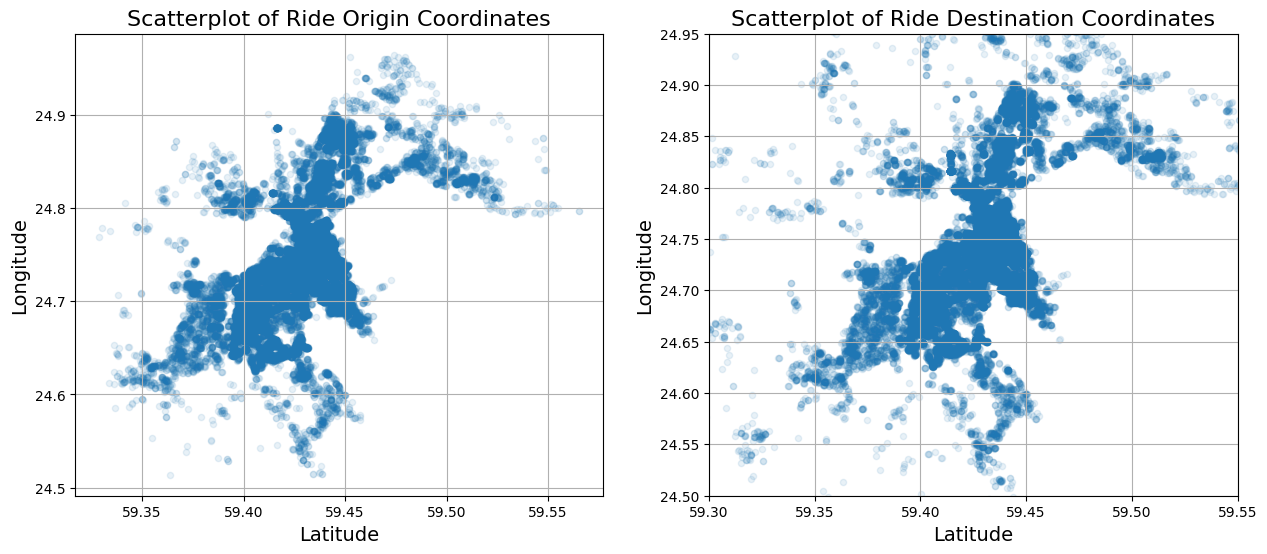

In [3]:
fig, ax = plt.subplots(1, 2, figsize=(15, 6))

df.sample(50000).plot.scatter(x='start_lat', y='start_lng', ax=ax[0], alpha=0.1)
ax[0].grid(True)
ax[0].set_xlabel('Latitude', fontsize=14)
ax[0].set_ylabel('Longitude', fontsize=14)
ax[0].set_title(f'Scatterplot of Ride Origin Coordinates', fontsize=16)


df.sample(50000).plot.scatter(x='end_lat', y='end_lng', ax=ax[1], alpha=0.1)
ax[1].grid(True)
# x and y axes clipped to ignore extremely far away end destinations
ax[1].set_xlim(59.3, 59.55)
ax[1].set_ylim(24.5, 24.95)
ax[1].set_xlabel('Latitude', fontsize=14)
ax[1].set_ylabel('Longitude', fontsize=14)
ax[1].set_title(f'Scatterplot of Ride Destination Coordinates', fontsize=16)

plt.show()

This scatterplot gives us a first impression of where the most rides start and end. As expected, the main parts of the city are feature prominently here. Nevertheless, it is difficult to make out any differences in density within these main regions in this simple plot.

Let's instead look at a KDE plot instead. Also, since the problem statement focuses on guiding the drivers towards areas with higher demand, **we focus below only on the ride origin distribution**.

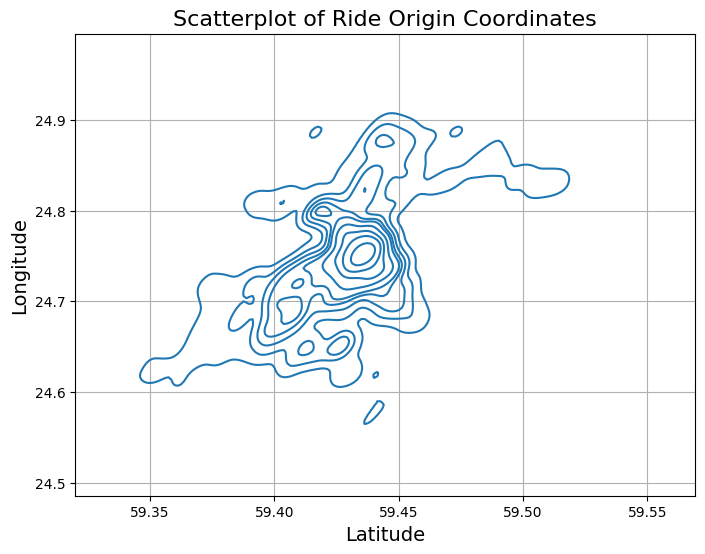

In [4]:
fig, ax = plt.subplots(figsize=(8, 6))

sns.kdeplot(data=df.sample(50000), x="start_lat", y="start_lng", ax=ax, warn_singular=False)
ax.grid(True)
ax.set_xlabel('Latitude', fontsize=14)
ax.set_ylabel('Longitude', fontsize=14)
ax.set_title(f'Scatterplot of Ride Origin Coordinates', fontsize=16)

plt.show()

**Takeaway**: There is an extremely dense area (probably the city centre) where a large number of rides originate from

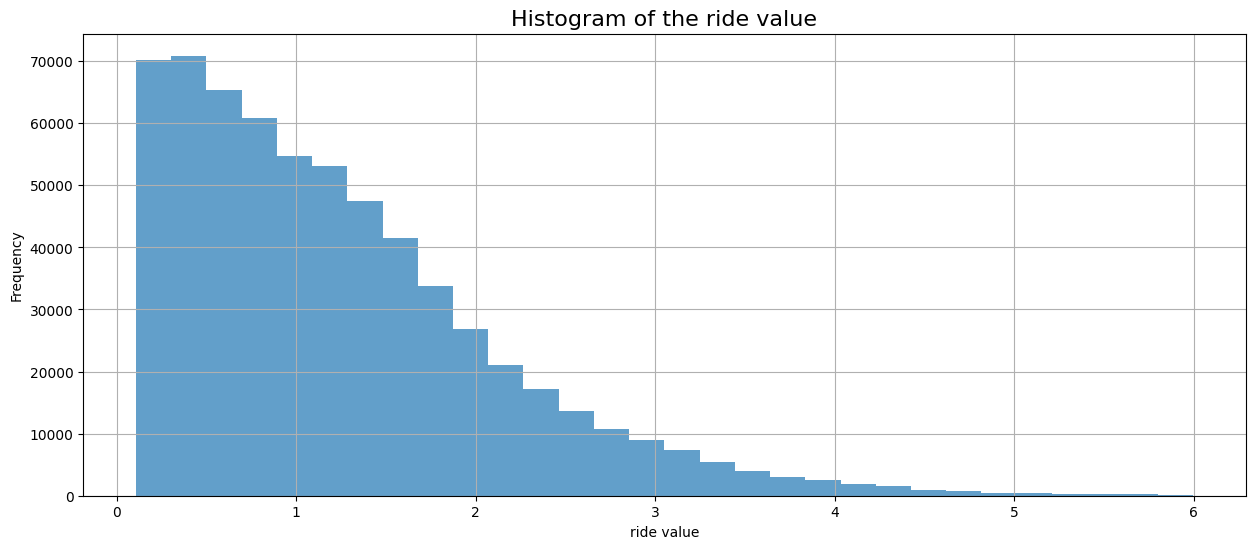

In [5]:
fig, ax = plt.subplots(figsize=(15, 6))

df.ride_value.plot.hist(bins=30, ax=ax, alpha=0.7)
ax.grid(True)
ax.set_title('Histogram of the ride value', fontsize=16)
ax.set_xlabel('ride value')

plt.show()

In [6]:
# ride values seem to be correct

df.loc[df.ride_value <= 0]

,start_time,start_lat,start_lng,end_lat,end_lng,ride_value


## Temporal Analysis of Data

In this section, we focus on the temporal aspects of the data.

In [7]:
# create column for the hour, day of month and day of week information
df['start_time'] = pd.to_datetime(df.start_time)
df['start_hour'] = df.start_time.dt.hour
df['start_day'] = df.start_time.dt.day
df['start_dayofweek'] = df.start_time.dt.day_name()

### High-level time series depiction of data (Hourly granularity)

In [8]:
rides_count_ts = (
    df
    .groupby(['start_hour', 'start_day'])
    .size()
    .reset_index()
    .sort_values(['start_day', 'start_hour'])
)

rides_count_ts.columns = ['start_hour', 'start_day', 'num_rides']
rides_count_ts = rides_count_ts.reset_index(drop=True)

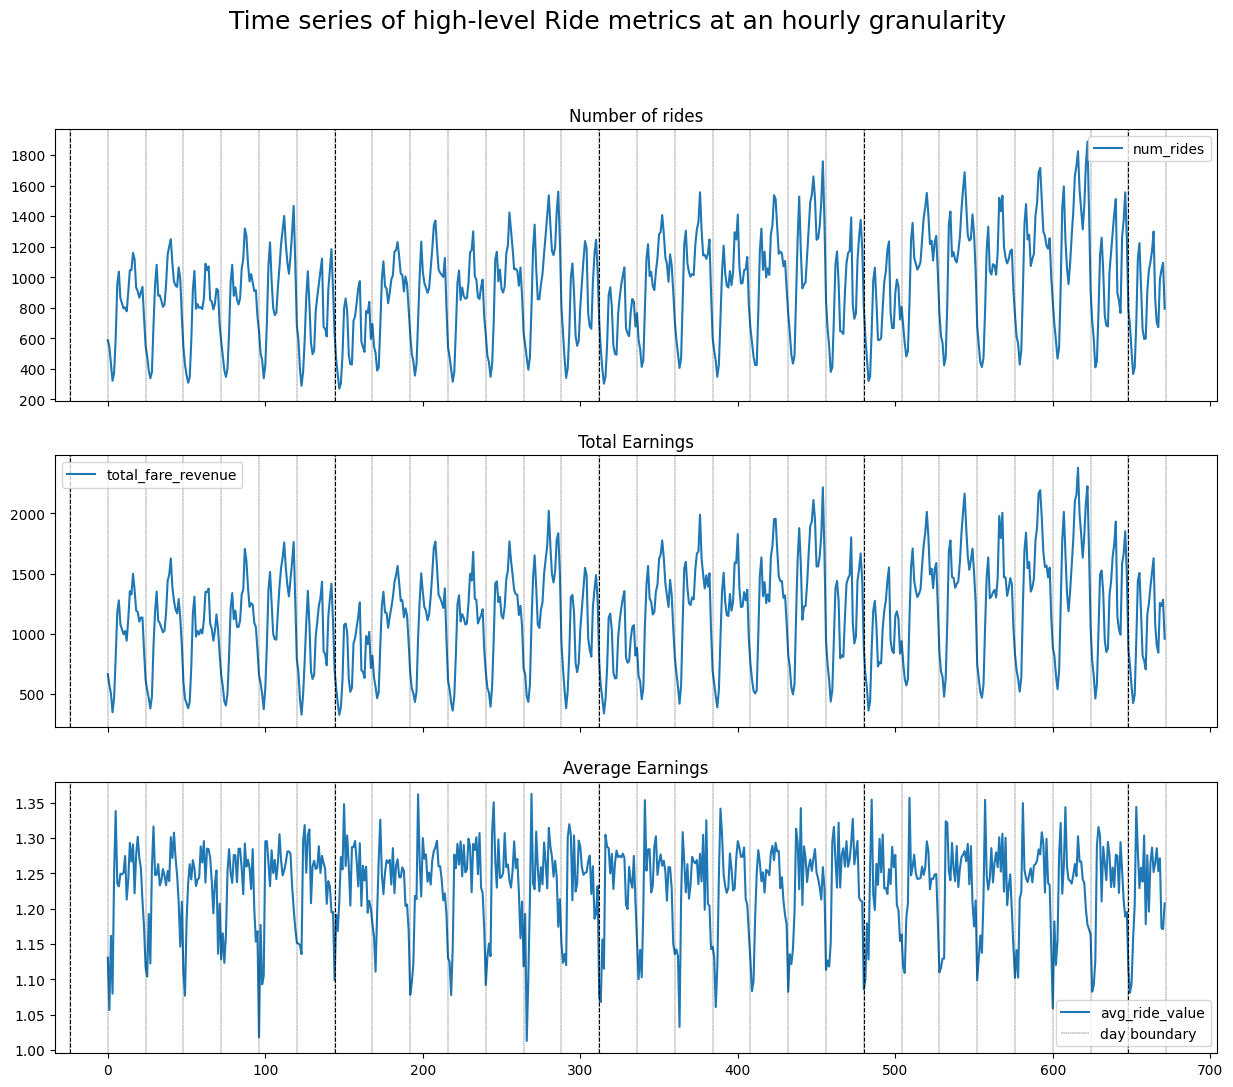

In [9]:
rides_earnings_ts = (
    df.loc[df.ride_value < 6]  # filtering some very high-level rides 
    .groupby(['start_hour', 'start_day'])
    .agg({'ride_value': ['sum', 'mean']})
    # ['ride_value'].mean()
    .reset_index()
    .sort_values(['start_day', 'start_hour'])
)

rides_earnings_ts.columns = ['start_hour', 'start_day', 'total_fare_revenue', 'avg_ride_value']
rides_earnings_ts = rides_earnings_ts.reset_index(drop=True)

fig, ax = plt.subplots(3, 1, figsize=(15, 12), sharex=True)

rides_count_ts.plot(y="num_rides", ax=ax[0])
rides_earnings_ts.plot(y="total_fare_revenue", ax=ax[1])
rides_earnings_ts.plot(y="avg_ride_value", ax=ax[2])

titles = [
    "Number of rides",
    "Total Earnings",
    "Average Earnings"
]
for i, title in enumerate(titles):
    ax[i].set_title(title)
    
    for vline in range(-24, 673, 24):
        if vline == 0:
            ax[i].axvline(vline, lw=0.3, c="k", linestyle='--', label='day boundary')
        else:
            ax[i].axvline(vline, lw=0.3, c="k", linestyle='--')
    
    for vline in range(-24, 673, 24*7):
        if vline == 0:
            ax[i].axvline(vline, lw=0.8, c="k", linestyle='--', label='week boundary')
        else:
            ax[i].axvline(vline, lw=0.8, c="k", linestyle='--')

plt.legend()
plt.suptitle("Time series of high-level Ride metrics at an hourly granularity", fontsize=18)
plt.show()

**Takeaways**: 

- There is a reasonably consistent **seasonality** in the number of rides and total earnings within a day and over a week.<br>
- There is a **slight but noticeable increasing trend** in the number of rides and total earnings.

### Intra-day earnings Distribution

How are the total earnings distributed over a day?

In [10]:
week_vs_time_earnings = (
    rides_earnings_ts
    .merge(
        df[['start_day', 'start_dayofweek']].drop_duplicates(), on=['start_day'], how='left')
    .groupby(["start_dayofweek", "start_hour"])
    .agg({'total_fare_revenue': ['sum', 'mean']})
    .reset_index()
)

week_vs_time_earnings.columns = ['start_dayofweek', 'start_hour','total_earnings', 'avg_earnings']
week_vs_time_earnings = week_vs_time_earnings.reset_index(drop=True)
# week_vs_time_earnings

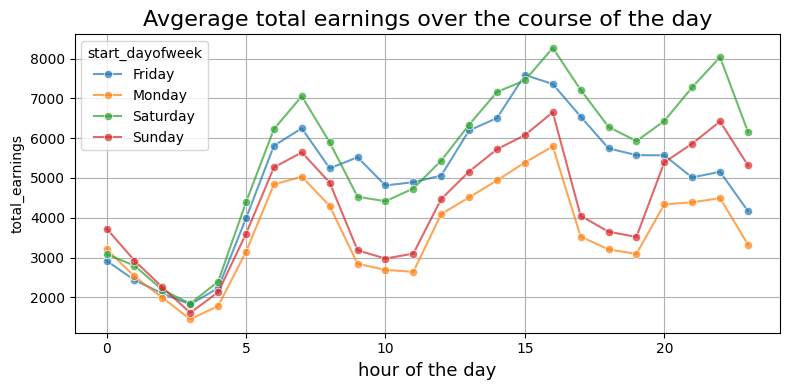

In [11]:
hourly_rev_distribution = week_vs_time_earnings.loc[~week_vs_time_earnings.start_dayofweek.isin(['Tuesday', 'Wednesday', 'Thursday'])]

fig, ax = plt.subplots(figsize=(8, 4), sharex=True)

sns.lineplot(data=hourly_rev_distribution, x="start_hour", y="total_earnings", hue="start_dayofweek", ax=ax, alpha=0.7, marker='o')

ax.grid(True)
ax.set_title('Avgerage total earnings over the course of the day', fontsize=16)
ax.set_xlabel('hour of the day', fontsize=13)

plt.tight_layout()
plt.show()

<!-- ## The total earnings on Saturday are almost 50% more than on Monday-->
**Takeaways**:
- There significant differences in earnings over a week. Monday and Saturday are the lowest and highest demand days respectively.<br>
- The total earnings on Saturday are almost 50% more than on Monday.

## Spatio-Temporal Analysis of Data

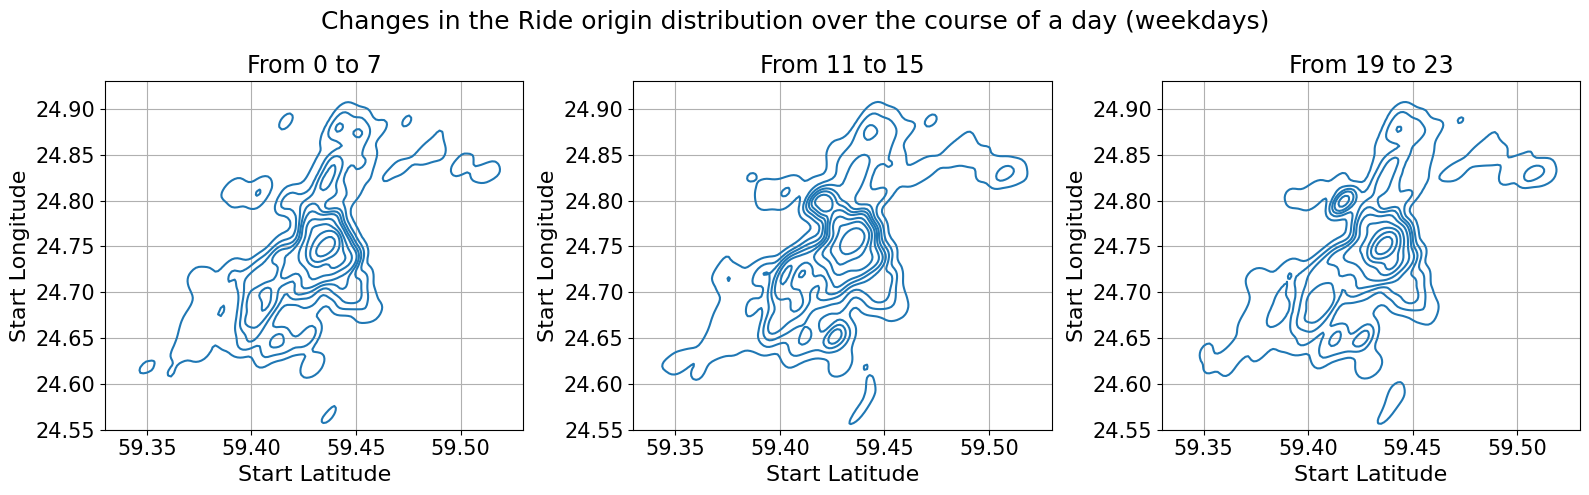

In [12]:
tmp_weekdays = df.loc[~df.start_dayofweek.isin(['Saturday', 'Sunday'])].copy()
tmp_weekdays['start_hour_bin'], bins = pd.qcut(tmp_weekdays["start_hour"], 5, labels=range(5), retbins=True)

# create time bins for labels in plots
bins = [*bins]
bins = [int(float(x)) for x in bins]
time_tuple = [*zip(bins[:-1], bins[1:]), (0, 0)]

fig, axs = plt.subplots(1, 3, figsize=(16, 5))

for i, ax in enumerate(axs.flatten()):

    sns.kdeplot(
        data=tmp_weekdays.loc[tmp_weekdays.start_hour_bin == 2*i], 
        x="start_lat", 
        y="start_lng", 
        ax=ax, 
        warn_singular=False
    )
    ax.grid(True)
    ax.set_xlim(59.33, 59.53)
    ax.set_ylim(24.55, 24.93)
    ax.tick_params(axis='both', which='major', labelsize=15)
    ax.set_xlabel("Start Latitude", fontsize=16)
    ax.set_ylabel("Start Longitude", fontsize=16)
    ax.set_title(f"From {time_tuple[2*i][0]} to {time_tuple[2*i][1]}", fontsize=17)

plt.suptitle("Changes in the Ride origin distribution over the course of a day (weekdays)", fontsize=18)
plt.tight_layout()
plt.show()

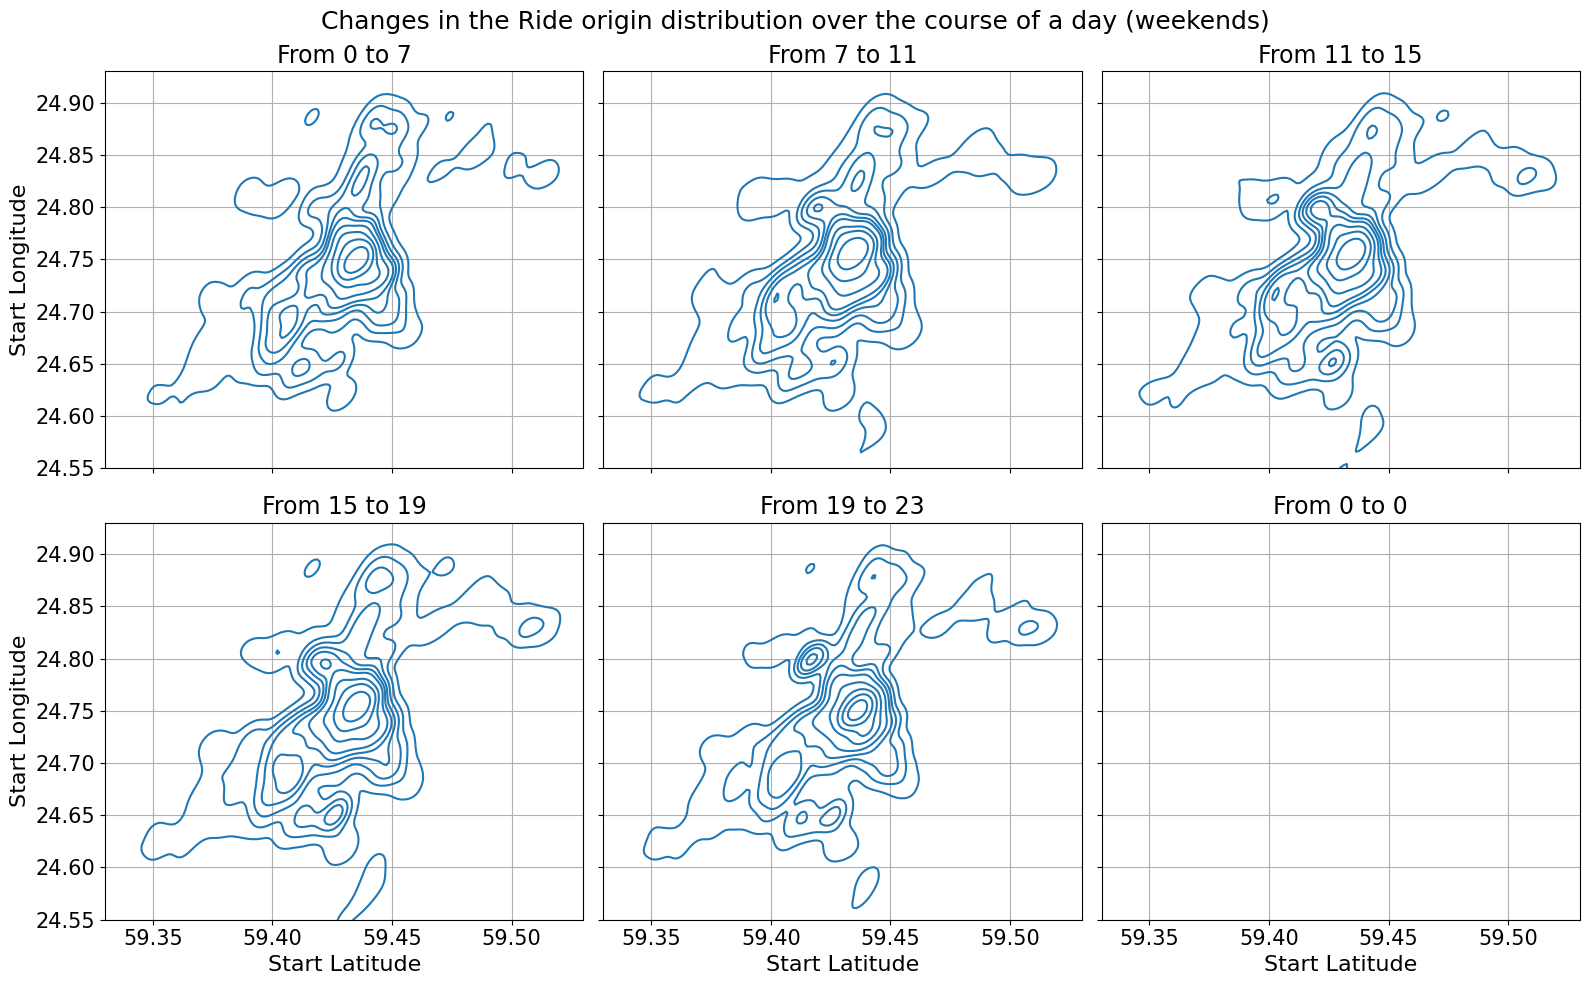

In [13]:
tmp_weekends = df.loc[df.start_dayofweek.isin(['Saturday', 'Sunday'])].copy()
tmp_weekends['start_hour_bin'] = pd.cut(tmp_weekends["start_hour"], bins, labels=range(5)).dropna()

fig, axs = plt.subplots(2, 3, figsize=(16, 10), sharex=True, sharey=True)

for i, ax in enumerate(axs.flatten()):
    sns.kdeplot(
        data=tmp_weekends.loc[tmp_weekends.start_hour_bin == i], 
        x="start_lat", 
        y="start_lng", 
        ax=ax, 
        warn_singular=False
    )
    ax.grid(True)
    ax.set_xlim(59.33, 59.53)
    ax.set_ylim(24.55, 24.93)
    ax.tick_params(axis='both', which='major', labelsize=15)
    ax.set_xlabel("Start Latitude", fontsize=16)
    ax.set_ylabel("Start Longitude", fontsize=16)
    ax.set_title(f"From {time_tuple[i][0]} to {time_tuple[i][1]}", fontsize=17)

plt.suptitle("Changes in the Ride origin distribution over the course of a day (weekends)", fontsize=18)
plt.tight_layout()
plt.show()

**Takeaway**: There are clear shifts in the distribution of ride origins throughout the day, but there are two observations we can make from this:
- The core of activity remains more or less unchanged
- The demand is spatially very well correlated.

## Spatio-Temporal Analysis of Data: A closer look

In this section, we divide the start location of the rides into zones based on a 5\*5 grid and analyse the time series of total ride values aggregated over an entire day. This 5\*5 grids is so constructed such that the total number of rides in each zone is the same.

In [14]:
from datetime import datetime
from darts.timeseries import TimeSeries, concatenate

def get_sk_date(date):
    """Get date as integer in the form of yyyymmdd"""
    return date.year * 10000 + date.month * 100 + date.day


def string_to_date(date_str):
    return datetime.strptime(date_str, "%Y-%m-%d").date()


week_boundaries = ['2022-03-01', '2022-03-08', '2022-03-15', '2022-03-22', '2022-03-29']
bins = [*map(lambda x: get_sk_date(string_to_date(x)), week_boundaries)]

df = df.loc[df.ride_value < 6]

# divide the latitudes and longitudes into 5 equal intervals based on total expected demand.
decile_buckets = np.linspace(0, 1, 6)
df['lat_bin'] = pd.qcut(df.start_lat, decile_buckets, labels=range(5))
df['lng_bin'] = pd.qcut(df.start_lng, decile_buckets, labels=range(5))
df['sk_start_time'] = df.start_time.apply(get_sk_date)
df['week_num'] = pd.cut(df.sk_start_time, bins=bins, labels=range(4), include_lowest=True)

ts_df = (
    df
    .groupby(
        ["lat_bin", "lng_bin", "week_num", "start_dayofweek"], 
        observed=False)
    .agg({'ride_value': 'sum'})  # sum of ride value is proxy for demand
    .reset_index()
)

time_index = (
    df
    .groupby(["week_num", "start_dayofweek"], observed=False)
    .size()
    .reset_index()
    .reset_index()
    .drop(columns=[0])
)
time_index.columns = ["time_col", "week_num", "start_dayofweek"]

complete_ts = ts_df.merge(time_index).set_index("time_col")

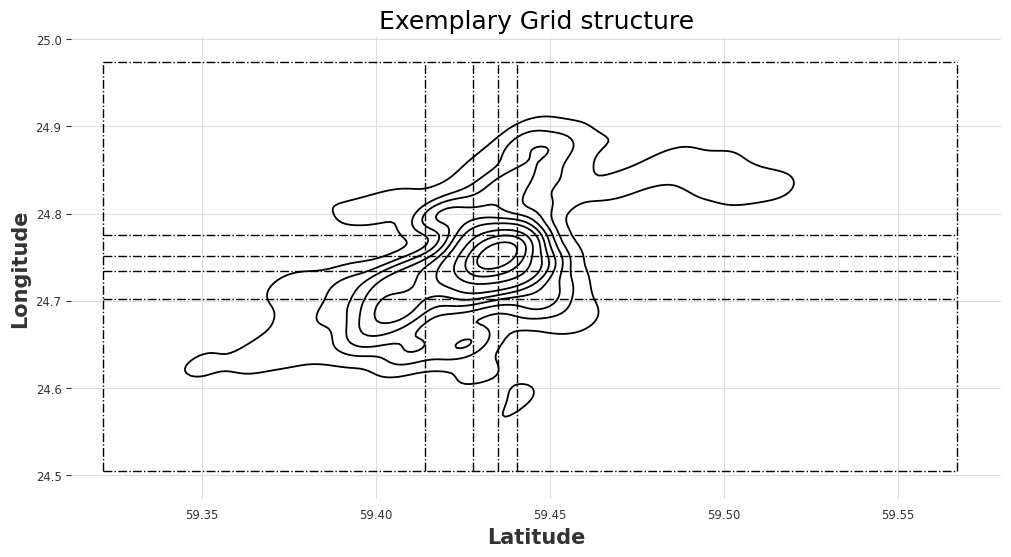

In [15]:
buckets = np.linspace(0, 1, 6)

lat_buckets = df.start_lat.quantile(q=buckets).values
lng_buckets = df.start_lng.quantile(q=buckets).values

fig, ax = plt.subplots(figsize=(12, 6))

sns.kdeplot(data=df.sample(5000), x="start_lat", y="start_lng", ax=ax, warn_singular=False)
plt.vlines(lat_buckets, ymin=lng_buckets[0], ymax=lng_buckets[-1], linestyles='dashdot', linewidth=1)
plt.hlines(lng_buckets, xmin=lat_buckets[0], xmax=lat_buckets[-1], linestyles='dashdot', linewidth=1)

ax.set_xlabel('Latitude', fontsize=15)
ax.set_ylabel('Longitude', fontsize=15)
ax.set_title(f'Exemplary Grid structure', fontsize=18)
plt.show()

In [16]:
# creating time series from Pandas DataFrame
time_series_list = (
    TimeSeries.from_group_dataframe(
        complete_ts, 
        ["lat_bin", "lng_bin"], # one time series for each combination of lat and lng bin
        time_col=None, # use index as time column
        drop_group_cols=["lat_bin", "lng_bin"],
        value_cols=["ride_value"])
)

/Users/paresh.nakhe/.pyenv/versions/venv_my_projects/lib/python3.11/site-packages/darts/timeseries.py:873: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  groups = df.groupby(group_cols[0] if len(group_cols) == 1 else group_cols)


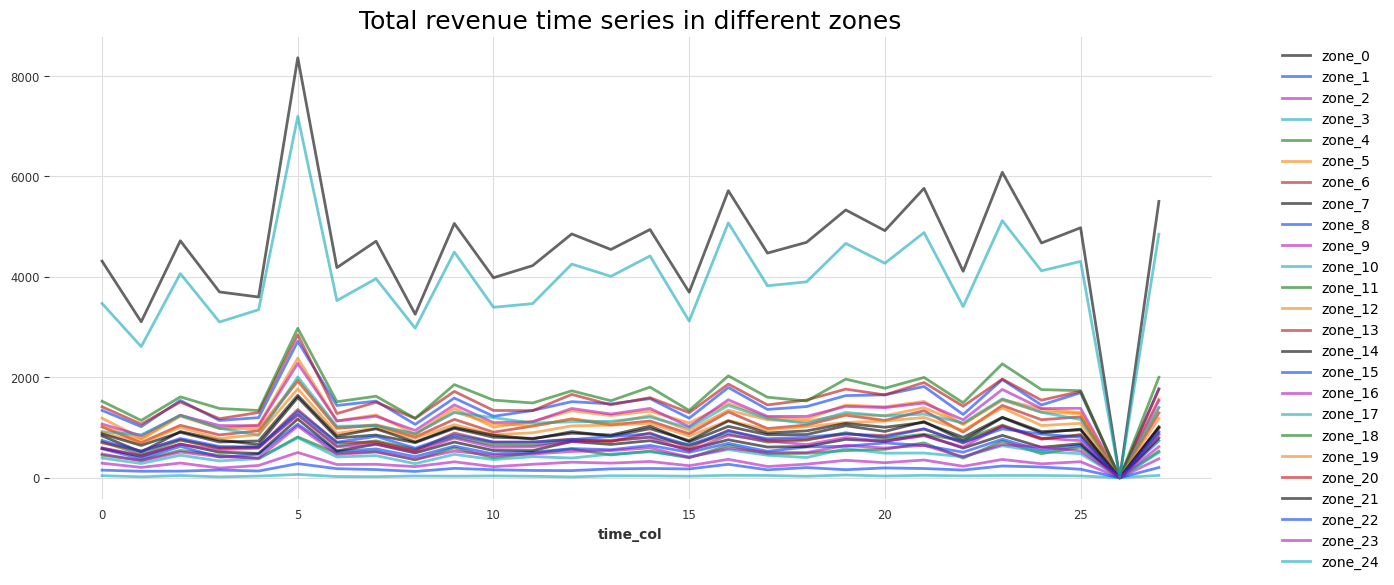

In [17]:
fig, ax = plt.subplots(figsize=(15, 6))

for i, ts in enumerate(time_series_list):
    ts.plot(ax=ax, label=f'zone_{i}', alpha=0.6)

plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
ax.set_title(f'Total revenue time series in different zones', fontsize=18)
plt.show()

**Takeaway**: 
- The total demand is in different zones shows high levels of correlation
- There is **one day with missing data(ride values)**

In real-world I'd investigate further into the causes for the missing data and if necessary impute the missing values using a method that best fits the needs. In my model proposal, lacking additional context, I am intentionally ignoring the fact there are missing values focusing instead on the design approach.